In [1]:
!wget https://www.dropbox.com/s/r4jgo2sigegfnf1/model.weights
!wget https://www.dropbox.com/s/lveee68z05cpic4/classes.names
!wget https://www.dropbox.com/s/klvnh1tx6yypjnb/darknet-yolov3.cfg
!wget https://www.dropbox.com/s/3rcicy5fwio5tjm/requirements.txt

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
!pip install -r requirements.txt

  Using cached appnope-0.1.2-py2.py3-none-any.whl (4.3 kB)
  Using cached python-Levenshtein-0.12.2.tar.gz (50 kB)
  Running setup.py clean for python-Levenshtein
Failed to build python-Levenshtein
    Running setup.py install for python-Levenshtein: started
    Running setup.py install for python-Levenshtein: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'c:\programdata\anaconda3\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Roshani\\AppData\\Local\\Temp\\pip-install-2suo2flh\\python-levenshtein_f10e83394f104693b00a0ecdd54bc4f0\\setup.py'"'"'; __file__='"'"'C:\\Users\\Roshani\\AppData\\Local\\Temp\\pip-install-2suo2flh\\python-levenshtein_f10e83394f104693b00a0ecdd54bc4f0\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\Roshani\AppData\Local\Temp\pip-wheel-alwpck5t'
       cwd: C:\Users\Roshani\AppData\Local\Temp\pip-install-2suo2flh\python-levenshtein_f10e83394f104693b00a0ecdd54bc4f0\
  Complete output (33 lines):
  running bdist_wheel
  running build
  running build_py
  creating build

In [3]:
import easyocr
import cv2
from PIL import Image
import imutils
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [4]:
reader = easyocr.Reader(['fa']) # need to run only once to load model into memory

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


## Detect plate with YOLO

### Initialize the parameters

In [5]:
confThreshold = 0.5  # Confidence threshold
nmsThreshold = 0.4  # Non-maximum suppression threshold

inpWidth = 416  # 608     # Width of network's input image
inpHeight = 416  # 608     # Height of network's input image

### Load names of classes

In [6]:
classesFile = "classes.names"
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

### Give the configuration and weight files for the model and load the network using them.

In [7]:
modelConfiguration = "darknet-yolov3.cfg"
modelWeights = "model.weights"

net = cv2.dnn.readNetFromDarknet(modelConfiguration,  modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [8]:
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [9]:
### Draw the predicted bounding box

In [10]:
def drawPred(img, classId, conf, left, top, right, bottom):
    # Draw a bounding box.
    #    cv.rectangle(img, (left, top), (right, bottom), (255, 178, 50), 3)
    cv2.rectangle(img, (left, top), (right, bottom), (0, 255, 0), 3)

    label = '%.2f' % conf

    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s: %s' % (classes[classId], label)

    # Display the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(
        label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(img, (left, top - round(1.5*labelSize[1])), (left + round(
        1.5*labelSize[0]), top + baseLine), (255, 0, 255), cv2.FILLED)
    #cv.rectangle(img, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine),    (255, 255, 255), cv.FILLED)
    cv2.putText(img, label, (left, top),
               cv2.FONT_HERSHEY_SIMPLEX, 0.70, (255, 255, 255), 2)

### Remove the bounding boxes with low confidence using non-maxima suppression

In [11]:
def postprocess(img, outs):
    imgHeight = img.shape[0]
    imgWidth = img.shape[1]

    classIds = []
    confidences = []
    boxes = []
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            # if detection[4]>0.001:
            scores = detection[5:]
            classId = np.argmax(scores)
            # if scores[classId]>confThreshold:
            confidence = scores[classId]
#             if detection[4] > confThreshold:
#                 print(detection[4], " - ", scores[classId],
#                       " - th : ", confThreshold)
#                 print(detection)
            if confidence > confThreshold:
                center_x = int(detection[0] * imgWidth)
                center_y = int(detection[1] * imgHeight)
                width = int(detection[2] * imgWidth)
                height = int(detection[3] * imgHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    plates = []
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        plate = np.array(img[top:top+height, left:left+width])
        plates.append(plate)
        drawPred(img, classIds[i], confidences[i], left,
                 top, left + width, top + height)

    return plates

In [12]:
def detect_plate(img):
    # Create a 4D blob from a img.
    blob = cv2.dnn.blobFromImage(
        img, 1/255, (inpWidth, inpHeight), [0, 0, 0], 1, crop=False)

    # Sets the input to the network
    net.setInput(blob)

    # Runs the forward pass to get output of the output layers
    outs = net.forward(getOutputsNames(net))

    # Remove the bounding boxes with low confidence
    plates = postprocess(img, outs)

    # Put efficiency information. The function getPerfProfile returns the overall time for inference(t) and the timings for each of the layers(in layersTimes)
    t, _ = net.getPerfProfile()
    label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
    cv2.putText(img, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

    return img , plates

## Show the image

In [13]:
def show_image(img):
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.imshow(img, interpolation='nearest')

In [14]:

def show_detectd_plates(img_detected, plates):
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.imshow(img_detected, interpolation='nearest')

    if(len(plates)>0):
        fig = plt.figure(figsize=(10., 12.))
        grid = ImageGrid(fig, 111, nrows_ncols=(4, len(plates)), axes_pad=0.1)
        for ax, im in zip(grid, plates):
            ax.imshow(im)

In [15]:
def resize_image(img):
    img = imutils.resize(img, width=800)
    return img

In [17]:
def mask_image(img):

    blank_mask = np.zeros(img.shape, dtype=np.uint8)
    original = img.copy()
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    lower = np.array([0, 0, 0])
    upper = np.array([255, 255,255])
    mask = cv2.inRange(hsv, lower, upper)

    cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    for c in cnts:
        cv2.drawContours(blank_mask,[c], -1, (255,255,255), -1)
        break

    result = cv2.bitwise_and(original,blank_mask)
    
    return result

In [18]:
def enhance_image(img):
    img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    img = cv2.threshold(cv2.GaussianBlur(img, (5, 5), 0), 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    img = cv2.bilateralFilter(img, 13, 15, 15)
    kernel = np.ones((9,9),np.uint8)
    edges = cv2.dilate(img,kernel,iterations = 1)
    kernel = np.ones((11,11),np.uint8)
    img = cv2.erode(edges,kernel,iterations = 1)
    img = cv2.bilateralFilter(img, 13, 21, 21)

    
    return img

In [19]:
def ocr(img):
    result = reader.readtext(img)
    return ' '.join(str(e[1]) for e in result)
#     if(len(result)>0):
#         return result[0][1]


In [20]:
def detect_show_plates(img):
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    show_image(rgb_img)
    img_detected, plates = detect_plate(rgb_img)
    show_detectd_plates(img_detected, plates)
    if(len(plates)>0):
        plate = plates[0]
        show_image(plate)
        plate = resize_image(plate)
        show_image(plate)
        plate = mask_image(plate)
        show_image(plate)
        plate = enhance_image(plate)
        show_image(plate)
        result = ocr(plate)
        print(result)
        
    

### Reading The Image


In [21]:
image_path = 'Car.jpg'
img = cv2.imread(image_path)

In [22]:
# from google.colab import files
# from io import BytesIO

# uploaded = files.upload()
# im = Image.open(BytesIO(list(uploaded.values())[0]))
# open_cv_image = np.array(im)
# base_image = open_cv_image[:, :, ::-1].copy() 

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


٦ر٦ ٢٢٢ ٥ ٨٦ ؟


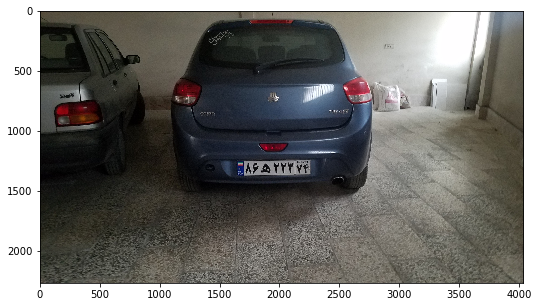

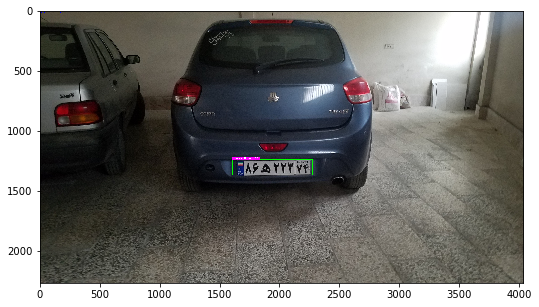

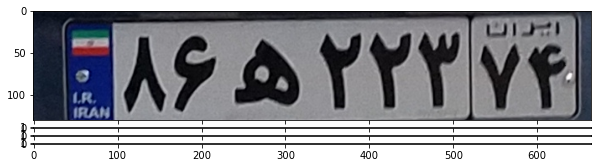

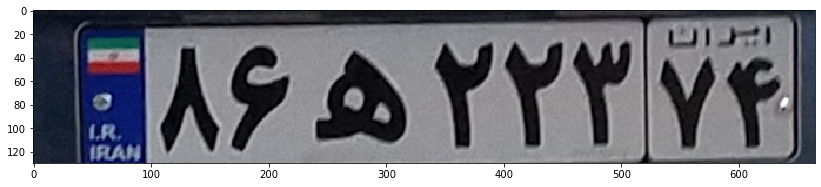

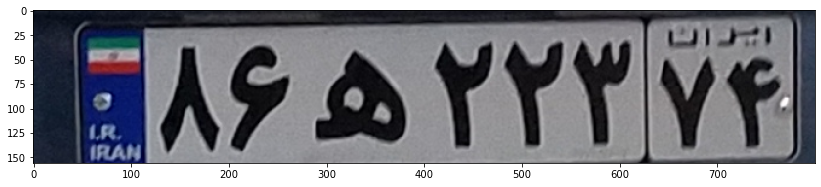

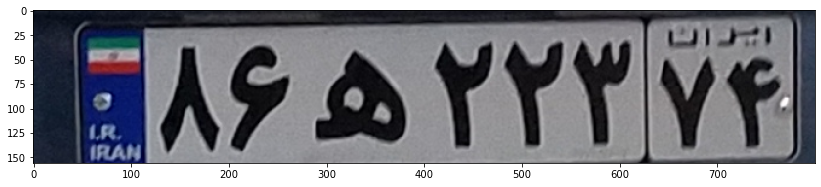

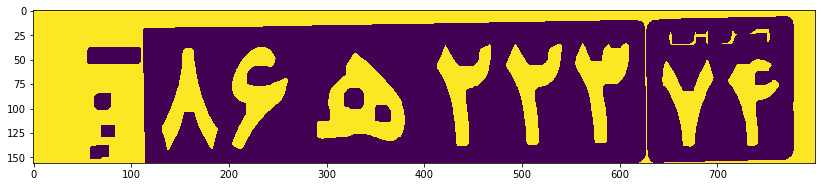

In [23]:
detect_show_plates(img)

In [24]:
def detect_plates_with_ocr(img):
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img_detected, plates = detect_plate(rgb_img)
    if(len(plates)>0):
        plate = plates[0]
        plate = resize_image(plate)
        plate = mask_image(plate)
        plate = enhance_image(plate)
        result = ocr(plate)
        return result,img_detected, plates
    return "",img_detected, plates

In [74]:
plate_number,_,_ = detect_plates_with_ocr(img)
print(plate_number)

٦ر٦ ٢٢٢ ٥ ٨٦ ؟


In [26]:
def show_image_with_title(img, title):
    fig, ax = plt.subplots(figsize=(8, 3))
    plt.title(title)
    ax.imshow(img, interpolation='nearest')

١٧٤٣س٦٦٢ ١٧٦٣٦س٦٢ 77.78
٣٤ ٧٢٤ ١ ٦٩٤ ٧٢٤٣٦ط٩٤ 53.85
٦٢٤ 9 ٤٧٥ ٤٧٥٣٦و٢٤ 54.55
 ٤٦٧٧٤ق٧٨ 0.0
١٣٥ب٩٢ ١٣٥٧٤ب٩٢ 75.0
ار الا ٦٥٢ 9 ٦٢ ٢٤٧ ٢٦٧١٢و٥٢ 28.57
٦ر٦ ٢٢٢ ٥ ٨٦ ؟ ٢٢٣٧٤ه٨٦ 22.22
 السا ١٢ ٦٥٣ى٢؟ ٦٥٣١٢ی٤٢ 35.29
هرا ٢٢ ٧٩٢ ٥ ٢٩ ٧٩٣١٢ه٢٩ 35.29
ا انا ٨٩١ ٦٣٥٥ ٧٤ ٨٩١٧٤ه٣٥ 38.89
٦ر ١٨٥ ٤ ٦٢٧ ١٨٥٩٩ج٢٧ 33.33
٦٢٤ ٥ ٦٢٢ ٦٣٤٧٤ق٣٣ 13.33
 ٢٢ ٨٥١ ٥ ٢٨ ٨٥١١٢ن٢٨ 42.86
٢٢ ٥٠٤٧٤ ٥ ٤٧٤١٢و٦٥ 38.46
٢٧ 9 ٨٥٧٥٣ ٨٥٧٧٤و٢٧ 38.46


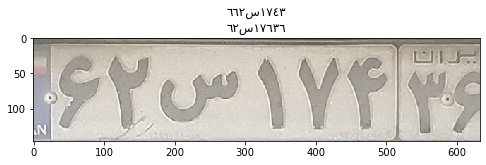

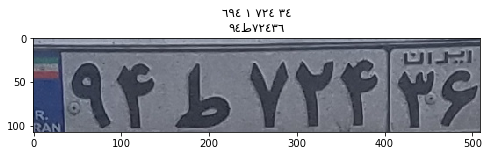

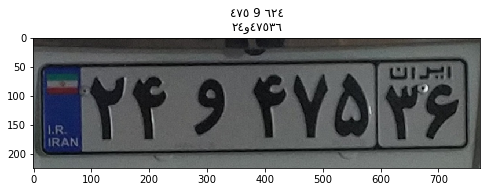

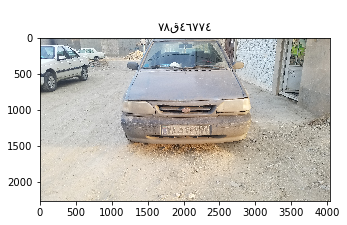

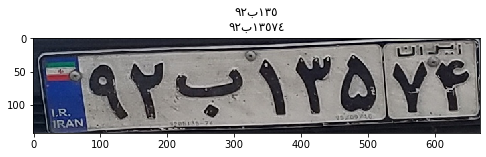

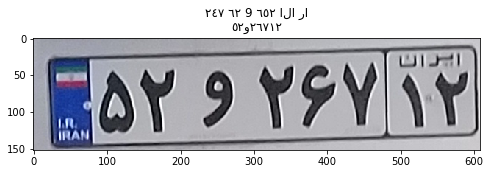

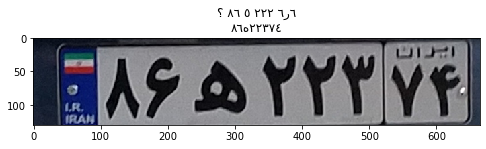

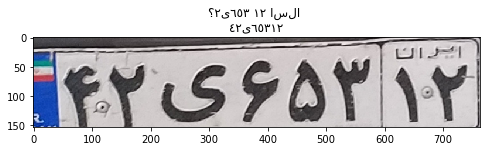

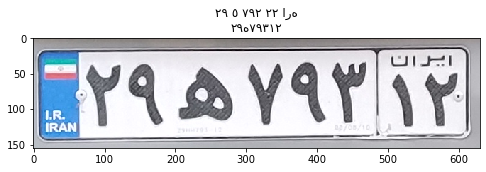

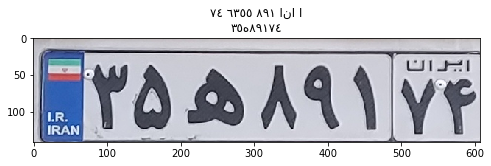

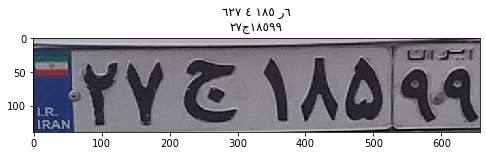

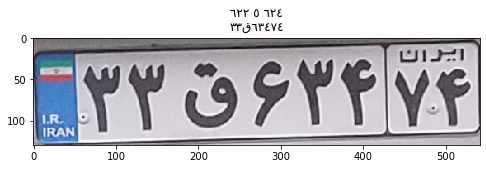

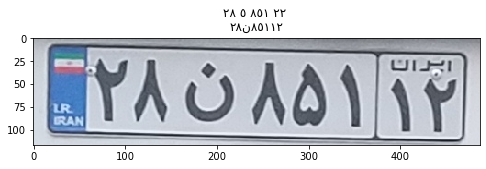

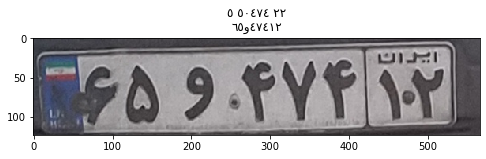

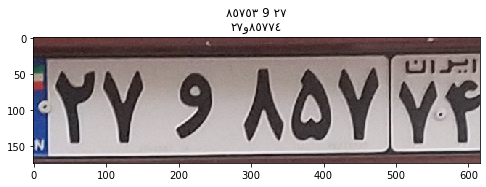

In [72]:
from PIL import Image
import glob
from bidi import algorithm as bidialg
import pandas as pd
import textdistance

mypath ="Test/*.jpg"
images = glob.glob(mypath)

fileLabels =  pd.read_csv('FileLabel.csv', encoding='utf-8')
file_lable_dict = dict(fileLabels.values)
summery =[]
for image in images[:15]:
    filename =image[5:]
    test_img = cv2.imread(image)
    plate_number, d_image, plates = detect_plates_with_ocr(test_img)
    score = round((textdistance.jaccard.similarity(plate_number, file_lable_dict[filename]) *100.00),2)
    print(plate_number, file_lable_dict[filename], str(score))
    summery .append ({'Filename': filename, 'IsPlateDetected': len(plates)>0 , 'Score':score,'p1':  file_lable_dict[filename], 'p2':plate_number})
  
    title = bidialg.get_display(plate_number+'\n'+file_lable_dict[filename])
    show_image_with_title(next(iter(plates or []), d_image),title)


In [73]:
table = pd.DataFrame(summery)
print(table)
print("")
print("PlateDetection: " + str((table.IsPlateDetected.sum() / len(summery)) *100)+"%")
print("Average Score: "+str( round(table.Score.mean(),2)) +"%" )

               Filename  IsPlateDetected  Score        p1                   p2
0   20210106_151120.jpg             True  77.78  ١٧٦٣٦س٦٢             ١٧٤٣س٦٦٢
1   20210106_151126.jpg             True  53.85  ٧٢٤٣٦ط٩٤         ٣٤ ٧٢٤ ١ ٦٩٤
2   20210106_153623.jpg             True  54.55  ٤٧٥٣٦و٢٤            ٦٢٤ 9 ٤٧٥
3   20210106_153659.jpg            False   0.00  ٤٦٧٧٤ق٧٨                     
4   20210106_153721.jpg             True  75.00  ١٣٥٧٤ب٩٢               ١٣٥ب٩٢
5   20210106_155423.jpg             True  28.57  ٢٦٧١٢و٥٢  ار الا ٦٥٢ 9 ٦٢ ٢٤٧
6   20210106_155431.jpg             True  22.22  ٢٢٣٧٤ه٨٦       ٦ر٦ ٢٢٢ ٥ ٨٦ ؟
7   20210106_155446.jpg             True  35.29  ٦٥٣١٢ی٤٢       السا ١٢ ٦٥٣ى٢؟
8   20210106_155455.jpg             True  35.29  ٧٩٣١٢ه٢٩      هرا ٢٢ ٧٩٢ ٥ ٢٩
9   20210106_155503.jpg             True  38.89  ٨٩١٧٤ه٣٥    ا انا ٨٩١ ٦٣٥٥ ٧٤
10  20210106_163642.jpg             True  33.33  ١٨٥٩٩ج٢٧         ٦ر ١٨٥ ٤ ٦٢٧
11  20210106_163651.jpg             True  13.33  ٦٣٤